In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import os
import gc
import tqdm
import random
import glob

import warnings
warnings.filterwarnings('ignore')

SEED = 42
np.random.seed(SEED)
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers, callbacks, layers, losses
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Input, Reshape, Conv2D, Conv2DTranspose, Flatten
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow_addons as tfa

tf.random.set_seed(SEED)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
        print(e)
        
def mish(x):
    return x*tf.math.tanh(tf.math.softplus(x))

def leakyrelu(x, factor=0.2):
    return tf.maximum(x, factor*x)

In [3]:
def ConvBlock(n, kernel_size=3, strides=2, bn=True, padding='same'):
    def f(x):
        x = Conv2D(n, kernel_size=kernel_size, strides=strides, padding=padding)(x)
        x = Activation(leakyrelu)(x)       
        if bn:
            x = BatchNormalization(momentum=0.8)(x)
        return x
    return f

def deConvBlock(n, kernel_size=3, strides=2, bn=True, padding='same'):
    def f(x):
        x = Conv2DTranspose(n, kernel_size=kernel_size, strides=strides, padding=padding)(x)
        x = Activation('relu')(x)       
        if bn:
            x = BatchNormalization(momentum=0.8)(x)
        return x
    return f

In [4]:
class D2GAN(keras.Model):
    def __init__(self, x_dim, z_dim): # dim: tuple
        super(D2GAN, self).__init__()
        self.x_dim = x_dim
        self.z_dim = z_dim
        
        self.alpha = 1
        self.beta = 1

        self.generator = self.build_generator()
        self.discriminator_1 = self.build_discriminator()
        self.discriminator_2 = self.build_discriminator()
        
    def compile(self, g_optim, d_optim_1, d_optim_2):
        super(D2GAN, self).compile()
        self.g_optim = g_optim
        self.d_optim_1 = d_optim_2
        self.d_optim_2 = d_optim_2
        
    def build_generator(self): 
        inputs = Input(shape = self.z_dim)
        
        x = Dense(128*7*7, activation='relu')(inputs)
        x = Reshape((7, 7, 128))(x) # 7, ,7 128
        x = BatchNormalization(momentum=0.8)(x)
        x = deConvBlock(64)(x) # 14, 14, 64
        x = deConvBlock(32)(x) # 28, 28, 32
        
        outputs = Conv2D(1, kernel_size=3, strides=1, activation='tanh', padding='same')(x) # 28, 28, 1
        return Model(inputs, outputs, name='generator')

    def build_discriminator(self):
        inputs = Input(shape = self.x_dim)
        
        x = ConvBlock(16)(inputs)
        x = ConvBlock(32)(x)
        x = ConvBlock(64)(x)
        x = Flatten()(x)
        
        outputs = Dense(1, activation='softplus')(x)
        return Model(inputs, outputs, name='discriminator')
    
    def train_step(self, x):
        batch_size = tf.shape(x)[0]
        
        noise = tf.random.normal((batch_size, self.z_dim))
        
        # discriminator
        with tf.GradientTape() as tape1, tf.GradientTape() as tape2:
            fake = self.generator(noise)

            d1_pred_x = self.discriminator_1(x)
            d1_pred_fake = self.discriminator_1(fake)
            
            d1_loss = tf.reduce_mean(-self.alpha*tf.math.log(d1_pred_x) + d1_pred_fake)
            
            d2_pred_x = self.discriminator_2(x)
            d2_pred_fake = self.discriminator_2(fake)
            
            d2_loss = tf.reduce_mean(d2_pred_x - self.beta*tf.math.log(d2_pred_fake))

        grads1 = tape1.gradient(d1_loss, self.discriminator_1.trainable_weights)
        self.d_optim_1.apply_gradients(zip(grads1, self.discriminator_1.trainable_weights))
        
        grads2 = tape2.gradient(d2_loss, self.discriminator_2.trainable_weights)
        self.d_optim_2.apply_gradients(zip(grads2, self.discriminator_2.trainable_weights))

        # generator
        with tf.GradientTape() as tape:
            fake = self.generator(noise)
            pred_1 = self.discriminator_1(fake)
            pred_2 = self.discriminator_2(fake)
            

            g_loss = tf.reduce_mean(-pred_1 + self.beta*tf.math.log(pred_2))
            
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optim.apply_gradients(zip(grads, self.generator.trainable_weights))

        return {'d1_loss': d1_loss, 'd2_loss' : d2_loss,  'g_loss': g_loss}

In [5]:
class PlotCallback(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0:
            r, c = 2, 5
            noise = np.random.normal(0, 1, (r*c, 100))
            imgs = self.model.generator.predict(noise)*0.5 +0.5
            imgs = imgs.reshape(r*c, 28, 28)
            fig, axs = plt.subplots(r, c)
            n = 0
            for i in range(r):
                for j in range(c):
                    axs[i,j].imshow(imgs[n], cmap='gray')
                    axs[i,j].axis('off')
                    n += 1
            plt.show()
            plt.close()

In [6]:
# prepare data
from tensorflow.keras.datasets import mnist
(train_X, train_y), (_, _) = mnist.load_data()
train_X = (train_X - 127.5)/127.5
train_X = np.expand_dims(train_X, -1)


In [7]:
gan = D2GAN(train_X.shape[1:], 100)
gan.compile(
    optimizers.Adam(2e-4, 0.5), 
    optimizers.Adam(2e-4, 0.5), 
    optimizers.Adam(2e-4, 0.5)
         )

In [8]:
gan.generator.summary()
gan.discriminator_1.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense (Dense)                (None, 6272)              633472    
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 128)         512       
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        73792     
_________________________________________________________________
activation (Activation)      (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        25

Epoch 1/101
469/469 [==============================] - ETA: 0s - d1_loss: -1.3353 - d2_loss: -1.1014 - g_loss: 1.1022

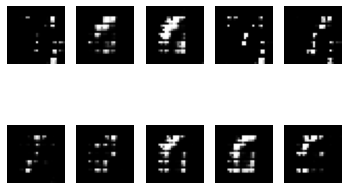

469/469 [==============================] - 11s 23ms/step - d1_loss: -1.3380 - d2_loss: -1.1042 - g_loss: 1.1052
Epoch 2/101
469/469 [==============================] - 10s 21ms/step - d1_loss: 0.8705 - d2_loss: 0.8547 - g_loss: -0.6615
Epoch 3/101
469/469 [==============================] - 10s 21ms/step - d1_loss: 0.7324 - d2_loss: 0.8221 - g_loss: -0.7237
Epoch 4/101
469/469 [==============================] - 10s 21ms/step - d1_loss: 0.8737 - d2_loss: 0.7625 - g_loss: -0.7552
Epoch 5/101
469/469 [==============================] - 10s 21ms/step - d1_loss: 0.8888 - d2_loss: 0.7800 - g_loss: -0.7293
Epoch 6/101
469/469 [==============================] - 10s 22ms/step - d1_loss: 0.8530 - d2_loss: 0.7438 - g_loss: -0.7039
Epoch 7/101
469/469 [==============================] - 10s 22ms/step - d1_loss: 0.8760 - d2_loss: 0.8033 - g_loss: -0.7424
Epoch 8/101
469/469 [==============================] - 10s 21ms/step - d1_loss: 0.8969 - d2_loss: 0.8312 - g_loss: -0.7722
Epoch 9/101
469/469 [======

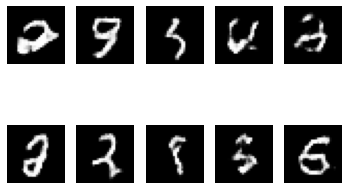

469/469 [==============================] - 10s 22ms/step - d1_loss: 0.9190 - d2_loss: 0.8659 - g_loss: -0.7978
Epoch 12/101
469/469 [==============================] - 10s 22ms/step - d1_loss: 0.9096 - d2_loss: 0.8720 - g_loss: -0.8000
Epoch 13/101
469/469 [==============================] - 10s 21ms/step - d1_loss: 0.9022 - d2_loss: 0.8725 - g_loss: -0.8094
Epoch 14/101
469/469 [==============================] - 10s 21ms/step - d1_loss: 0.8915 - d2_loss: 0.8696 - g_loss: -0.8092
Epoch 15/101
469/469 [==============================] - 10s 22ms/step - d1_loss: 0.8821 - d2_loss: 0.8733 - g_loss: -0.8156
Epoch 16/101
469/469 [==============================] - 10s 22ms/step - d1_loss: 0.8813 - d2_loss: 0.8728 - g_loss: -0.8184
Epoch 17/101
469/469 [==============================] - 10s 21ms/step - d1_loss: 0.8891 - d2_loss: 0.8771 - g_loss: -0.8052
Epoch 18/101
469/469 [==============================] - 10s 22ms/step - d1_loss: 0.8912 - d2_loss: 0.8745 - g_loss: -0.8220
Epoch 19/101
469/469 

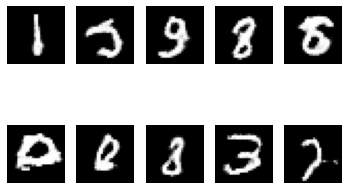

469/469 [==============================] - 10s 22ms/step - d1_loss: 0.9160 - d2_loss: 0.8915 - g_loss: -0.8256
Epoch 22/101
469/469 [==============================] - 10s 22ms/step - d1_loss: 0.9178 - d2_loss: 0.8946 - g_loss: -0.8437
Epoch 23/101
469/469 [==============================] - 10s 22ms/step - d1_loss: 0.9278 - d2_loss: 0.8928 - g_loss: -0.8549
Epoch 24/101
469/469 [==============================] - 10s 22ms/step - d1_loss: 0.9313 - d2_loss: 0.9021 - g_loss: -0.85900s - d1_loss: 0.9312 - d2_loss: 0.9020 - g_loss: -0.85
Epoch 25/101
469/469 [==============================] - 10s 22ms/step - d1_loss: 0.9343 - d2_loss: 0.9056 - g_loss: -0.8659
Epoch 26/101
469/469 [==============================] - 10s 21ms/step - d1_loss: 0.9408 - d2_loss: 0.9136 - g_loss: -0.8609
Epoch 27/101
469/469 [==============================] - 10s 21ms/step - d1_loss: 0.9452 - d2_loss: 0.9201 - g_loss: -0.8609
Epoch 28/101
469/469 [==============================] - 10s 22ms/step - d1_loss: 0.9438 - d

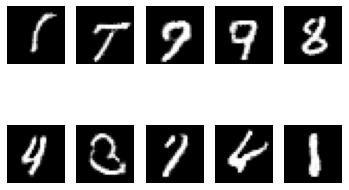

469/469 [==============================] - 10s 22ms/step - d1_loss: 0.9509 - d2_loss: 0.9339 - g_loss: -0.8864
Epoch 32/101
469/469 [==============================] - 10s 22ms/step - d1_loss: 0.9540 - d2_loss: 0.9405 - g_loss: -0.8915
Epoch 33/101
469/469 [==============================] - 10s 21ms/step - d1_loss: 0.9545 - d2_loss: 0.9400 - g_loss: -0.8887
Epoch 34/101
469/469 [==============================] - 10s 22ms/step - d1_loss: 0.9567 - d2_loss: 0.9439 - g_loss: -0.8960
Epoch 35/101
469/469 [==============================] - 10s 22ms/step - d1_loss: 0.9582 - d2_loss: 0.9480 - g_loss: -0.8886
Epoch 36/101
469/469 [==============================] - 10s 22ms/step - d1_loss: 0.9566 - d2_loss: 0.9448 - g_loss: -0.9043
Epoch 37/101
469/469 [==============================] - 10s 22ms/step - d1_loss: 0.9594 - d2_loss: 0.9491 - g_loss: -0.8913
Epoch 38/101
469/469 [==============================] - 10s 22ms/step - d1_loss: 0.9577 - d2_loss: 0.9478 - g_loss: -0.9029
Epoch 39/101
469/469 

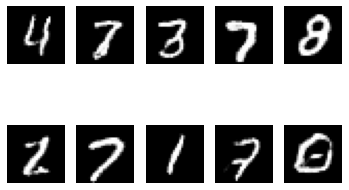

469/469 [==============================] - 11s 22ms/step - d1_loss: 0.9613 - d2_loss: 0.9538 - g_loss: -0.9030
Epoch 42/101
469/469 [==============================] - 10s 21ms/step - d1_loss: 0.9593 - d2_loss: 0.9515 - g_loss: -0.9107
Epoch 43/101
469/469 [==============================] - 10s 22ms/step - d1_loss: 0.9660 - d2_loss: 0.9528 - g_loss: -0.9007
Epoch 44/101
469/469 [==============================] - 10s 21ms/step - d1_loss: 0.9603 - d2_loss: 0.9523 - g_loss: -0.9139
Epoch 45/101
469/469 [==============================] - 10s 21ms/step - d1_loss: 0.9667 - d2_loss: 0.9560 - g_loss: -0.9003
Epoch 46/101
469/469 [==============================] - 10s 21ms/step - d1_loss: 0.9623 - d2_loss: 0.9548 - g_loss: -0.9120
Epoch 47/101
469/469 [==============================] - 10s 22ms/step - d1_loss: 0.9625 - d2_loss: 0.9557 - g_loss: -0.9168
Epoch 48/101
469/469 [==============================] - 10s 21ms/step - d1_loss: 0.9663 - d2_loss: 0.9579 - g_loss: -0.9131
Epoch 49/101
469/469 

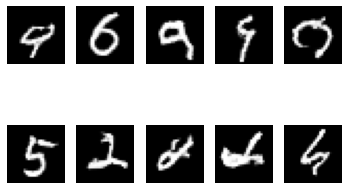

469/469 [==============================] - 10s 22ms/step - d1_loss: 0.9669 - d2_loss: 0.9616 - g_loss: -0.9080
Epoch 52/101
469/469 [==============================] - 10s 21ms/step - d1_loss: 0.9664 - d2_loss: 0.9590 - g_loss: -0.9176
Epoch 53/101
469/469 [==============================] - 10s 21ms/step - d1_loss: 0.9655 - d2_loss: 0.9594 - g_loss: -0.9208
Epoch 54/101
469/469 [==============================] - 10s 22ms/step - d1_loss: 0.9699 - d2_loss: 0.9601 - g_loss: -0.9151
Epoch 55/101
469/469 [==============================] - 10s 22ms/step - d1_loss: 0.9653 - d2_loss: 0.9627 - g_loss: -0.9270
Epoch 56/101
469/469 [==============================] - 10s 22ms/step - d1_loss: 0.9689 - d2_loss: 0.9639 - g_loss: -0.9134
Epoch 57/101
469/469 [==============================] - 10s 21ms/step - d1_loss: 0.9689 - d2_loss: 0.9582 - g_loss: -0.9252
Epoch 58/101
469/469 [==============================] - 10s 22ms/step - d1_loss: 0.9701 - d2_loss: 0.9618 - g_loss: -0.9114
Epoch 59/101
469/469 

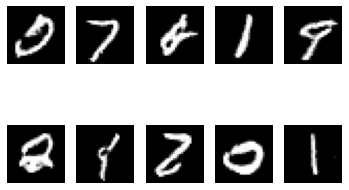

469/469 [==============================] - 10s 22ms/step - d1_loss: 0.9719 - d2_loss: 0.9635 - g_loss: -0.9210
Epoch 62/101
469/469 [==============================] - 10s 22ms/step - d1_loss: 0.9719 - d2_loss: 0.9624 - g_loss: -0.9212
Epoch 63/101
469/469 [==============================] - 10s 22ms/step - d1_loss: 0.9694 - d2_loss: 0.9640 - g_loss: -0.9280
Epoch 64/101
469/469 [==============================] - 10s 22ms/step - d1_loss: 0.9721 - d2_loss: 0.9628 - g_loss: -0.9249
Epoch 65/101
469/469 [==============================] - 10s 22ms/step - d1_loss: 0.9725 - d2_loss: 0.9650 - g_loss: -0.9178
Epoch 66/101
469/469 [==============================] - 10s 22ms/step - d1_loss: 0.9737 - d2_loss: 0.9656 - g_loss: -0.9195
Epoch 67/101
469/469 [==============================] - 10s 22ms/step - d1_loss: 0.9719 - d2_loss: 0.9652 - g_loss: -0.9238
Epoch 68/101
469/469 [==============================] - 10s 22ms/step - d1_loss: 0.9722 - d2_loss: 0.9642 - g_loss: -0.9233
Epoch 69/101
469/469 

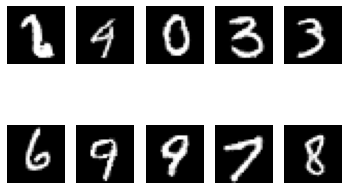

469/469 [==============================] - 10s 22ms/step - d1_loss: 0.9703 - d2_loss: 0.9633 - g_loss: -0.9261
Epoch 72/101
469/469 [==============================] - 10s 21ms/step - d1_loss: 0.9713 - d2_loss: 0.9674 - g_loss: -0.9249
Epoch 73/101
469/469 [==============================] - 10s 22ms/step - d1_loss: 0.9723 - d2_loss: 0.9628 - g_loss: -0.9240
Epoch 74/101
469/469 [==============================] - 10s 22ms/step - d1_loss: 0.9721 - d2_loss: 0.9650 - g_loss: -0.9260
Epoch 75/101
469/469 [==============================] - 10s 22ms/step - d1_loss: 0.9739 - d2_loss: 0.9661 - g_loss: -0.9228
Epoch 76/101
469/469 [==============================] - 10s 21ms/step - d1_loss: 0.9723 - d2_loss: 0.9639 - g_loss: -0.9217
Epoch 77/101
469/469 [==============================] - 10s 21ms/step - d1_loss: 0.9726 - d2_loss: 0.9657 - g_loss: -0.9296
Epoch 78/101
469/469 [==============================] - 10s 22ms/step - d1_loss: 0.9715 - d2_loss: 0.9647 - g_loss: -0.9290
Epoch 79/101
469/469 

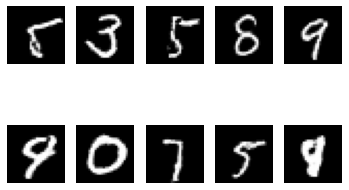

469/469 [==============================] - 10s 22ms/step - d1_loss: 0.9742 - d2_loss: 0.9669 - g_loss: -0.9238
Epoch 82/101
469/469 [==============================] - 10s 22ms/step - d1_loss: 0.9736 - d2_loss: 0.9658 - g_loss: -0.9222
Epoch 83/101
469/469 [==============================] - 10s 22ms/step - d1_loss: 0.9711 - d2_loss: 0.9668 - g_loss: -0.9296
Epoch 84/101
469/469 [==============================] - 10s 22ms/step - d1_loss: 0.9722 - d2_loss: 0.9652 - g_loss: -0.9305
Epoch 85/101
469/469 [==============================] - 10s 22ms/step - d1_loss: 0.9747 - d2_loss: 0.9655 - g_loss: -0.9303
Epoch 86/101
469/469 [==============================] - 10s 22ms/step - d1_loss: 0.9729 - d2_loss: 0.9653 - g_loss: -0.9231
Epoch 87/101
469/469 [==============================] - 10s 21ms/step - d1_loss: 0.9730 - d2_loss: 0.9644 - g_loss: -0.9277
Epoch 88/101
469/469 [==============================] - 10s 22ms/step - d1_loss: 0.9740 - d2_loss: 0.9653 - g_loss: -0.9292
Epoch 89/101
469/469 

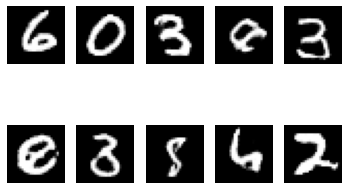

469/469 [==============================] - 10s 22ms/step - d1_loss: 0.9750 - d2_loss: 0.9690 - g_loss: -0.9322
Epoch 92/101
469/469 [==============================] - 10s 22ms/step - d1_loss: 0.9741 - d2_loss: 0.9680 - g_loss: -0.9286
Epoch 93/101
469/469 [==============================] - 10s 22ms/step - d1_loss: 0.9731 - d2_loss: 0.9666 - g_loss: -0.9323
Epoch 94/101
469/469 [==============================] - 10s 21ms/step - d1_loss: 0.9735 - d2_loss: 0.9675 - g_loss: -0.9268
Epoch 95/101
469/469 [==============================] - 10s 21ms/step - d1_loss: 0.9743 - d2_loss: 0.9683 - g_loss: -0.9294
Epoch 96/101
469/469 [==============================] - 10s 21ms/step - d1_loss: 0.9742 - d2_loss: 0.9668 - g_loss: -0.9376
Epoch 97/101
469/469 [==============================] - 10s 21ms/step - d1_loss: 0.9743 - d2_loss: 0.9678 - g_loss: -0.9278
Epoch 98/101
469/469 [==============================] - 10s 22ms/step - d1_loss: 0.9741 - d2_loss: 0.9675 - g_loss: -0.9361
Epoch 99/101
469/469 

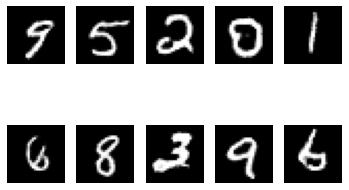

469/469 [==============================] - 10s 22ms/step - d1_loss: 0.9757 - d2_loss: 0.9667 - g_loss: -0.9339


In [9]:
gan.fit(train_X,
       epochs=101,
       shuffle=True,
       callbacks=[PlotCallback()],
       batch_size=128)